# Linear Regression and Regularization

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

import sklearn
%matplotlib inline

import ipywidgets as widgets
from tqdm.notebook import tqdm

import warnings
# silence future deprecation warnings
warnings.filterwarnings('ignore')

## Prepare the data

Although linear regression is a linear machine learning method, you can have nonlinear dependencies if you transform some of the independent variables by a nonlinear function. By doing this, you can improve the fit of your method. Let us demonstrate this on a house price dataset from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). Note that this dataset is not identical with one you used in the linear regression exercise, since the this dataset is too small and would cause unreliable evaluation results.

In [2]:
df_house = pd.read_csv("kc_house_data.csv")
df_house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We would like to have a simple linear regression problem with only one independent variable. Thus, we only keep *price* and *sqft_living*.

In [3]:
df_house = df_house[["price","sqft_living"]]
df_house.head()

,price,sqft_living
0,221900.0,1180
1,538000.0,2570
2,180000.0,770
3,604000.0,1960
4,510000.0,1680


### Split the data

We split the data into a training and test set

In [4]:
train_house, test_house = train_test_split(df_house, test_size=0.5, random_state=42)

### Normalize the data
Let us normalize the data by using *min-max normalization*

In [5]:
scaler = MinMaxScaler()

train_house = pd.DataFrame(scaler.fit_transform(train_house), columns=train_house.columns, index=train_house.index)
test_house = pd.DataFrame(scaler.transform(test_house), columns=test_house.columns, index=test_house.index)

train_house.head()

,price,sqft_living
493,0.117092,0.263499
4253,0.151895,0.269978
18621,0.095222,0.223542
1463,0.082309,0.063715
12026,0.090590,0.184665


In [6]:
X_train_house = train_house[["sqft_living"]]
y_train_house = train_house[["price"]]

X_test_house = test_house[["sqft_living"]]
y_test_house = test_house[["price"]]

## Bias term
To account for the bias term, we add a column containing only ones.

In [7]:
X_train_house["bias"] = 1
X_test_house["bias"] = 1

# Force order
X_train_house = X_train_house[["bias", "sqft_living"]]
X_test_house = X_test_house[["bias", "sqft_living"]]

X_train_house.head()

,bias,sqft_living
493,1,0.263499
4253,1,0.269978
18621,1,0.223542
1463,1,0.063715
12026,1,0.184665


## Fit a linear regression model
Define a linear regression function to estimate the parameters $\theta$ based on the normal equation:
  
  $\Theta:=(X^{\top}X)^{-1}(X^{\top}y)$

In [8]:
def fit(X, y):
    XTX = np.matmul(X.T, X)
    XTXinv = np.linalg.inv(XTX)
    XTy = np.matmul(X.T, y)

    return np.matmul(XTXinv, XTy)

Run the following code to check your implementation:

In [9]:
thetas = fit(X_train_house, y_train_house)

expected_thetas = np.array([[7.39560812e-05], [4.94185750e-01]])
np.testing.assert_array_almost_equal(thetas, expected_thetas, decimal=4)

## Predict prices
Using $X$ and the estimated $\theta$, predict the house prices on the training data

In [10]:
def predict(X, thetas):
    y_pred = np.dot(X, thetas)
    return y_pred

In [11]:
y_pred_house = predict(X_train_house, thetas)
y_pred_house

array([[1.30291368e-01],
       [1.33493435e-01],
       [1.10545285e-01],
       ...,
       [9.29339134e-02],
       [7.39560812e-05],
       [1.46835383e-01]])

## Visualize predictions
Let us plot house prices and predicted house prices

In [12]:
def plot_regression_line(X, thetas, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    deg = len(thetas)-1
    poly = PolynomialFeatures(deg)
    
    xs = np.arange(X.min(), X.max()+0.1, 0.01).reshape(-1,1)
    x = poly.fit_transform(xs)
    y_pred = np.dot(x, thetas)
    
    ax.plot(xs, y_pred, color="r")

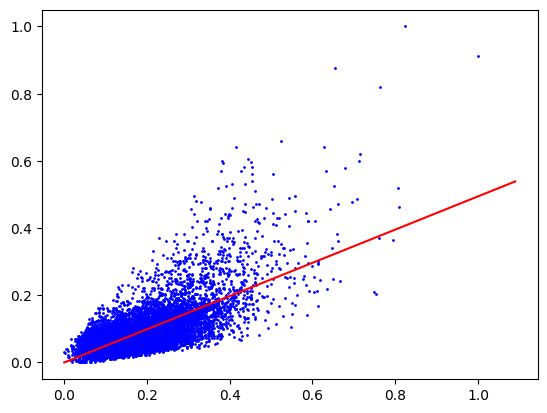

In [13]:
fig, ax = plt.subplots()
ax.plot(X_train_house["sqft_living"].values, y_train_house.values, "bo", markersize=1)
plot_regression_line(X_train_house["sqft_living"].values, thetas, ax)

## Calculate model performance
Now let's check how good our model performs by calculating the $R^2$ score on the test set.

In [14]:
y_pred_test_house = predict(X_test_house, thetas)
r2 = r2_score(y_test_house, y_pred_test_house)
r2

0.4922625693576085

## Adding polynomial features

We aim to improve the fit by adding $x^2$ as additional independent variable.

In [15]:
X_train_deg2 = X_train_house.copy()
X_train_deg2["sqft_living^2"] = X_train_deg2["sqft_living"] * X_train_deg2["sqft_living"]

X_test_deg2 = X_test_house.copy()
X_test_deg2["sqft_living^2"] = X_test_deg2["sqft_living"] * X_test_deg2["sqft_living"]
X_test_deg2.head()

,bias,sqft_living,sqft_living^2
735,1,0.182505,0.033308
2830,1,0.272138,0.074059
4106,1,0.366091,0.134022
16218,1,0.451404,0.203765
19964,1,0.234341,0.054916


### Fit the model with the additonal features

In [16]:
thetas_deg2 = fit(X_train_deg2, y_train_house)

### Calculate the performance

In [17]:
y_pred_test_deg2 = predict(X_test_deg2, thetas_deg2)
r2 = r2_score(y_test_house, y_pred_test_deg2)
r2

0.5380558719345014

As we can see, by adding $x^2$ as additional independent variable we could slightly improve our performance.

Let's try if we can further improve our performance by adding more polynomial features. To generate our polynomial features we will use the Scikit-Learn function [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). 

In [18]:
@widgets.interact(poly_deg =(1,18,1))
def f(poly_deg=1):
    poly = PolynomialFeatures(poly_deg)
    X_train_deg = poly.fit_transform(X_train_house["sqft_living"].values.reshape(-1,1))
    X_test_deg = poly.transform(X_test_house["sqft_living"].values.reshape(-1,1))

    thetas_deg = fit(X_train_deg, y_train_house)
    
    y_pred_test = predict(X_test_deg, thetas_deg)
    y_pred_train = predict(X_train_deg, thetas_deg)
    
    r2_test = r2_score(y_test_house, y_pred_test)
    r2_train = r2_score(y_train_house, y_pred_train)
    print("R2 Train {0:.5f}".format(r2_train))
    print("R2 Test {0:.5f}".format(r2_test))
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,10))
    ax0.set_title("Training data - polynomial degree {}".format(poly_deg))
    ax0.plot(X_train_house["sqft_living"], y_train_house["price"], "bo", markersize=1)
    plot_regression_line(X_train_deg, thetas_deg, ax0)
    
    ax1.set_title("Test data - polynomial degree {}".format(poly_deg))
    ax1.plot(X_test_house["sqft_living"], y_test_house["price"], "bo", markersize=1)
    plot_regression_line(X_test_deg, thetas_deg, ax1)

interactive(children=(IntSlider(value=1, description='poly_deg', max=18, min=1), Output()), _dom_classes=('wid…

What do you recognize when you increase the polynomial degree?

> Answer the question on ILIAS

## Regularization

The effect of overfitting can be reduced by regularization. Implement the regularized version of linear regression: $\Theta:=(X^{\top}X+\lambda \begin{bmatrix}
    0  & 0 &\ldots&0 \\
    0 & 1 & \\
    \ldots & & \ddots & \\
    0& & & 1
  \end{bmatrix} )^{-1}(X^{\top}y)$

In [19]:
def fit_reg(X, y, lam):
    num_rows, num_columns = X.shape
    I = np.identity(num_columns)
    I[0, 0] = 0

    XTX = np.matmul(X.T, X)

    XTXreg = XTX + (lam * I)
    XTXreginv = np.linalg.inv(XTXreg)
    XTy = np.matmul(X.T, y)

    return np.matmul(XTXreginv, XTy)

You can check your implementation by executing the following cell:

In [20]:
expected_thetas = np.array([[0.00178927], [0.48482755]])
actual_thetas = fit_reg(X_train_house, y_train_house, lam=2)

np.testing.assert_array_almost_equal(expected_thetas, actual_thetas)

We  plot the graph using the regularized parameter vectors. As you can see, the effect of overfitting is strongly reduced.

In [21]:
@widgets.interact(poly_deg = (0,12,1), lam=(0,100,1))
def f(poly_deg=1, lam=4):
    poly = PolynomialFeatures(poly_deg)
    X_train_deg = poly.fit_transform(X_train_house["sqft_living"].values.reshape(-1,1))
    X_test_deg = poly.transform(X_test_house["sqft_living"].values.reshape(-1,1))

    thetas_deg = fit_reg(X_train_deg, y_train_house, lam=lam)
    
    y_pred_test = predict(X_test_deg, thetas_deg)
    y_pred_train = predict(X_train_deg, thetas_deg)
    
    r2_test = r2_score(y_test_house, y_pred_test)
    r2_train = r2_score(y_train_house, y_pred_train)
    print("R2 Train", r2_train)
    print("R2 Test", r2_test)
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20,10))
    ax0.set_title("Training data - polynomial degree {}".format(poly_deg))
    ax0.plot(X_train_house["sqft_living"], y_train_house["price"], "bo", markersize=1)
    plot_regression_line(X_train_deg, thetas_deg, ax0)
    
    ax0.set_title("Test data - polynomial degree {}".format(poly_deg))
    ax1.plot(X_test_house["sqft_living"], y_test_house["price"], "bo", markersize=1)
    plot_regression_line(X_test_deg, thetas_deg, ax1)

interactive(children=(IntSlider(value=1, description='poly_deg', max=12), IntSlider(value=4, description='lam'…

Find the best configuration of **polynomial degree** and $\lambda$

poly_deg = 3
lambda_ = 3

## Regularization to help with numerical issues

Another benefit of regularization is that it can help in case of numerical issues. Let us consider our original dataset.

In [22]:
df_house_2 = pd.read_csv("kc_house_data.csv")
df_house_2 = df_house_2[["price","sqft_living","bedrooms"]]
df_house_2.head()

,price,sqft_living,bedrooms
0,221900.0,1180,3
1,538000.0,2570,3
2,180000.0,770,2
3,604000.0,1960,4
4,510000.0,1680,3


In [23]:
train_house_2, test_house_2 = train_test_split(df_house_2, test_size=0.5, random_state=42)

In [24]:
scaler = MinMaxScaler()

train_house_2 = pd.DataFrame(scaler.fit_transform(train_house_2), columns=train_house_2.columns, index=train_house_2.index)
test_house_2 = pd.DataFrame(scaler.transform(test_house_2), columns=test_house_2.columns, index=test_house_2.index)

test_house_2.head()

,price,sqft_living,bedrooms
735,0.056463,0.182505,0.4
2830,0.155871,0.272138,0.5
4106,0.190266,0.366091,0.4
16218,0.280130,0.451404,0.3
19964,0.125253,0.234341,0.3


To make the feature matrix $X^{\top}X$ singular, we just add  another independent variable (Size2) to X
that amounts to just twice the Size.

In [25]:
train_house_2["sqft_living2"] = 2 * train_house_2["sqft_living"]
train_house_2["bias"] = 1

test_house_2["sqft_living2"]= 2 * test_house_2["sqft_living"]
test_house_2["bias"] = 1

test_house_2.head()

,price,sqft_living,bedrooms,sqft_living2,bias
735,0.056463,0.182505,0.4,0.365011,1
2830,0.155871,0.272138,0.5,0.544276,1
4106,0.190266,0.366091,0.4,0.732181,1
16218,0.280130,0.451404,0.3,0.902808,1
19964,0.125253,0.234341,0.3,0.468683,1


In [26]:
X_train_house_2 = train_house_2[["bias", "sqft_living", "bedrooms", "sqft_living2"]]
y_train_house_2 = train_house_2[["price"]]

X_test_house_2 = test_house_2[["bias", "sqft_living", "bedrooms", "sqft_living2"]]
y_test_house_2 = test_house_2[["price"]]

We see that the linear regression fails, since $X^{\top}X$ is not invertible.

In [27]:
thetas = fit(X_train_house_2, y_train_house_2)

LinAlgError: Singular matrix

There are two possiblities to tackle this issue, the first one is to use the pseudoinverse instead of the inverse
and the second one is using regularization. 

> Try out both. 

*Hint*: For conducting linear regression with the pseudoinverse, you have to slightly modify the linear_regression method given further above. 
The numpy function [np.linalg.pinv](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) becomes handy for this.

In [28]:
def fit_pseudoinverse(X,y):
    XTX = np.matmul(X.T, X)
    XTXinv = np.linalg.pinv(XTX)
    XTy = np.matmul(X.T, y)

    return np.matmul(XTXinv, XTy)

Run this code to check your implementation

In [29]:
thetas_pseudo_inverse = fit_pseudoinverse(X_train_house_2, y_train_house_2)
print ("thetas obtained by linear regression with pseudoinverse:\n", thetas_pseudo_inverse)

expected_thetas_pseudo_inverse = np.array([
    [ 0.02902459],
    [ 0.11220321],
    [-0.12253607],
    [ 0.22440641]])

np.testing.assert_array_almost_equal(thetas_pseudo_inverse, expected_thetas_pseudo_inverse, decimal=5)

thetas obtained by linear regression with pseudoinverse:
           0
0  0.029025
1  0.112203
2 -0.122536
3  0.224406


In [30]:
thetas_regularization = fit_reg(X_train_house_2, y_train_house_2, lam=1)
print ("thetas obtained by linear regression with regularization:\n", thetas_regularization)

expected_thetas_regularization = np.array([
    [ 0.02846346],
    [ 0.11163748],
    [-0.11932519],
    [ 0.22327497]])

np.testing.assert_array_almost_equal(thetas_regularization, expected_thetas_regularization, decimal=5)

thetas obtained by linear regression with regularization:
           0
0  0.028463
1  0.111637
2 -0.119325
3  0.223275


## Programming Assignment
> Solve the following Programming assignment and check your solution in the Illias Quiz **Linear Regression and Regularization - Notebook Verification**.

Before you implemented Linear Regression from Scratch in this Programming assignment you are asked to use the scikit-learn implementation of the Linear Regression. [Scikit-learn Documentation](https://scikit-learn.org/stable/). Use the same data as before.

Use the following features: bedrooms, bathrooms, sqft_living, yr_built and grade

In [ ]:
df_house_sk = pd.read_csv("kc_house_data.csv")
df_house_sk = df_house_sk[["price", "bedrooms","bathrooms","sqft_living", "yr_built", "grade"]]

Use the same train/test split as in the previous examples

In [ ]:
train_house_sk, test_house_sk = train_test_split(df_house_sk, test_size=0.5, random_state=42)

X_train_house_sk = train_house_sk[["sqft_living", "bedrooms", "bathrooms", "yr_built", "grade"]]
y_train_house_sk = train_house_sk[["price"]]

X_test_house_sk = test_house_sk[["sqft_living", "bedrooms", "bathrooms", "yr_built", "grade"]]
y_test_house_sk = test_house_sk[["price"]]

Import and train the sklearn Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train_house_sk, y_train_house_sk)

Calculate the train and test score (there is a function for the regressor)

In [ ]:
reg.score(X_train_house_sk, y_train_house_sk)

0.6253849868773608

In [ ]:
reg.score(X_test_house_sk, y_test_house_sk)

0.6046449023246881

Put the test score in the Ilias Quiz 04a Notebook Verification

In [ ]:
0.6046449023246881

Also answer if this performs better than the ones calculated previously.

In [ ]:
Yes

In [ ]:
reg.coef_

array([[   168.06704967, -49981.76673704,  61642.11995795,
         -3928.44524816, 134173.14170272]])